In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import time
import imageio
from IPython.display import HTML
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,mean_squared_error,log_loss
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')


In [2]:
my_cmap=matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

In [3]:
np.random.seed(0)

In [4]:
data,labels=make_blobs(1000,2,4,random_state=0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


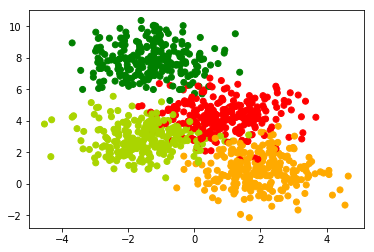

In [5]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

In [6]:
#creating train and test data
X_train,X_val,Y_train,Y_val=train_test_split(data,labels,stratify=labels,random_state=0)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(750, 2) (250, 2) (750,) (250,)


In [7]:
#converting in  One hot encoder form
enc=OneHotEncoder()

In [8]:
Y_train_oh=enc.fit_transform(np.expand_dims(Y_train,axis=1)).toarray()
Y_train_oh.shape

(750, 4)

# Creating Multiclass classifier with different Init function

In [9]:
class FFMI:
    
    def __init__(self,init_fun='Random',activation_fun="Sigmoid",leaky_slope=0.1):
        self.params = {}
        self.params_h=[]
        self.num_layers=2
        self.layer_sizes=[2,2,4]
        self.activation_fun=activation_fun
        self.leaky_slope=leaky_slope
        
        np.random.seed(0)
        
        if init_fun == 'Random':
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
                self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
                
        elif init_fun == "he":
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i]
                                                       )*np.sqrt(2/self.layer_sizes[i-1])
                self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
                
        elif init_fun == 'xavier':
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i]
                                                       )*np.sqrt(1/self.layer_sizes[i-1])
                self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
                
        elif init_fun == 'zeros':
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.zeros((self.layer_sizes[i-1],self.layer_sizes[i]))
                self.params["B"+str(i)]=np.zeros((1,self.layer_sizes[i]))
                
        self.gradients = {}
        self.update_params = {}
        self.prev_update_params = {}
        for i in range(1,self.num_layers+1):
            self.update_params["v_w"+str(i)]=0
            self.update_params["v_b"+str(i)]=0
            self.update_params["m_b"+str(i)]=0
            self.update_params["m_w"+str(i)]=0
            self.prev_update_params["v_w"+str(i)]=0
            self.prev_update_params["v_b"+str(i)]=0
            
    
    def forward_activation(self,X):
        if self.activation_fun=='sigmoid':
            return 1.0/(1.0 + np.exp(-X))
        elif self.activation_fun=="tanh":
            return np.tanh(X)
        elif self.activation_fun=="relu":
            return np.maximum(0,X)
        elif self.activation_fun=='leaky_relu':
            return np.maximum(self.leaky_slope * X,X)
        
    def grad_activation(self,X):
        if self.activation_fun=='sigmoid':
            return X*(1-X)
        elif self.activation_fun=="tanh":
            return (1-np.square(X))
        elif self.activation_fun=="relu":
            return 1.0*(X>0)
        elif self.activation_fun=='leaky_relu':
            d=np.zeros_like(X)
            d[X<=0]=self.leaky_slope
            d[X>0]=1.0
            return d
    
    def softmax(self,X):
        exps=np.exp(X)
        return exps/np.sum(exps,axis=1).reshape(-1,1)
    
    def forward_pass(self,X,params=None):
        if params is None:
            params=self.params
        self.A1=np.matmul(X,params["W1"]) + params["B1"] #(n,2) * (2,2) -> (n,2)
        self.H1=self.forward_activation(self.A1)
        self.A2=np.matmul(self.H1,params["W2"]) + params["B2"] #(n,2) * (2,4) -> (n,4)
        self.H2=self.softmax(self.A2)
        return self.H2
    
    def grad(self,X,Y,params=None):
        if params==None:
            params=self.params
            
        self.forward_pass(X,params)
        self.gradients["dA2"]=self.H2-Y #(N,4)
        self.gradients["dW2"]=np.matmul(self.H1.T,self.gradients["dA2"]) #(2,n)*(n,4)->(2,4)
        self.gradients["dB2"]=np.sum(self.gradients["dA2"],axis=0).reshape(1,-1) #(1,4)
        self.gradients["dH1"]=np.matmul(self.gradients["dA2"],params["W2"].T)#(N,4)*(4,2)->(n,2)
        self.gradients["dA1"]=np.multiply(self.gradients["dH1"],self.grad_activation(self.H1))#(n,2)
        self.gradients["dW1"]=np.matmul(X.T,self.gradients["dA1"]) #(2,n)*(n,2)->(2,2)
        self.gradients["dB1"]=np.sum(self.gradients["dA1"],0).reshape(1,-1)
        
    def predict(self,X):
        y_pred=self.forward_pass(X)
        return np.array(y_pred).squeeze()
    
    def  fit(self, X, Y, epochs=100, algo= "GD", display_loss=True, 
          eta=1, mini_batch_size=64, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9):
        
        if display_loss:
            loss = {}
            Y_pred=self.forward_pass(X)
            loss[0]=log_loss(np.argmax(Y,axis=1),Y_pred)
            
        for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            m = X.shape[0]
      
            if algo == "GD":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
            elif algo == "MiniBatch":
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    for i in range(1,self.num_layers+1):
                        self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
                        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
            elif algo == "Momentum":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
            elif algo == "NAG":
                temp_params = {}
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
                    temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
                    temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
                self.grad(X,Y,temp_params)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
                    self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
                self.prev_update_params=self.update_params 
        
            elif algo == "AdaGrad":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
                    self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
                    self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
            elif algo == "RMSProp":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
                    self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
                    self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
            elif algo == "Adam":
                self.grad(X, Y)
                num_updates=0
                for i in range(1,self.num_layers+1):
                    num_updates+=1
                    self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
                    self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
                    m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
                    v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
                    self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
                    self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
                    m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
                    v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
          
            if display_loss:
                Y_pred = self.predict(X)
                loss[num_epoch+1] = log_loss(np.argmax(Y, axis=1), Y_pred)
                self.params_h.append(np.concatenate((self.params['W1'].ravel(), self.params['W2'].ravel(), self.params['B1'].ravel(), self.params['B2'].ravel())))
    
        if display_loss:
            plt.plot(loss.values(), '-o', markersize=5)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()
        
                

In [10]:
def post_process(scatter_plot=True,Gradient_plot=True,plot_scale=0.1):
    Y_pred_train=model.predict(X_train)
    Y_pred_train=np.argmax(Y_pred_train,axis=1)
    Y_pred_val=model.predict(X_val)
    Y_pred_val=np.argmax(Y_pred_val,axis=1)
    accuracy_train=accuracy_score(Y_pred_train,Y_train)
    accuracy_val=accuracy_score(Y_pred_val,Y_val)
    print("Training accuracy is:",round(accuracy_train,4))
    print("Validation accuracy is:",round(accuracy_val,4))
    
    if scatter_plot:
        plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=my_cmap,s=15*(np.abs(
            Y_pred_train-Y_train)+0.1))
        plt.show()
        
    if Gradient_plot:
        h=np.asarray(model.params_h)
        h_diff = (h[0:-1,:]-h[1:,:])
        for i in range(18):
            plt.subplot(6,3,i+1)
            plt.plot(h_diff[:,i],'-')
            plt.ylim((-plot_scale, plot_scale))
            plt.yticks([])
            plt.xticks([])
        plt.show()

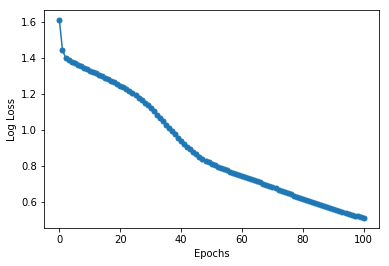

Training accuracy is: 0.8813
Validation accuracy is: 0.888


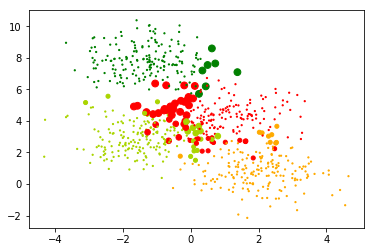

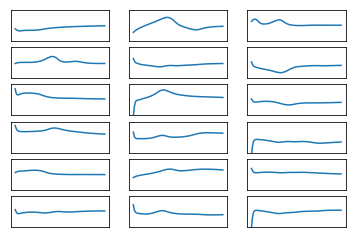

In [12]:
model = FFMI(init_fun='xavier', activation_fun='sigmoid')
model.fit(X_train, Y_train_oh, epochs=100, eta=1, algo="GD", display_loss=True)
post_process()


Initialization_function = zeros 
 Activation_Function = sigmoid 
 ALgo = GD



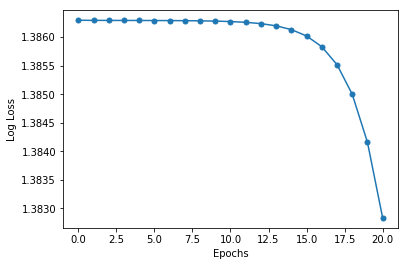

Training accuracy is: 0.2507
Validation accuracy is: 0.248


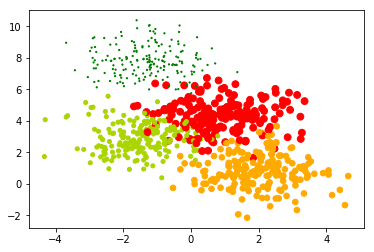

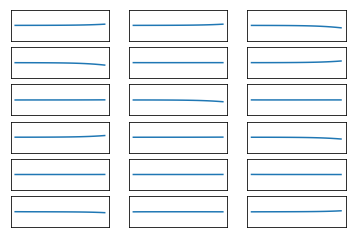




 ------------------




Initialization_function = zeros 
 Activation_Function = sigmoid 
 ALgo = MiniBatch



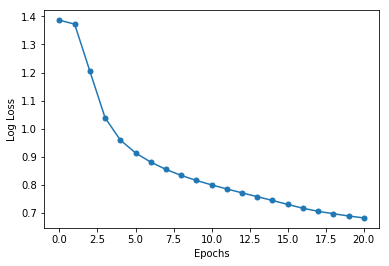

Training accuracy is: 0.7307
Validation accuracy is: 0.724


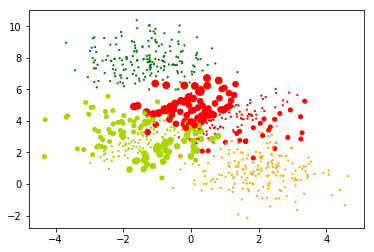

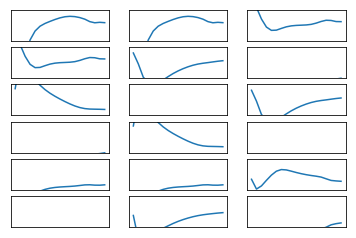




 ------------------




Initialization_function = zeros 
 Activation_Function = sigmoid 
 ALgo = NAG



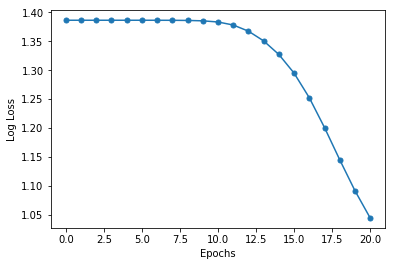

Training accuracy is: 0.5187
Validation accuracy is: 0.532


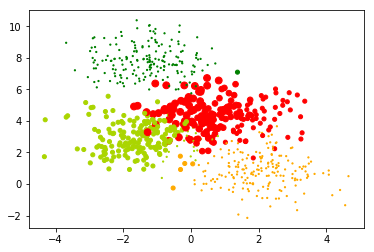

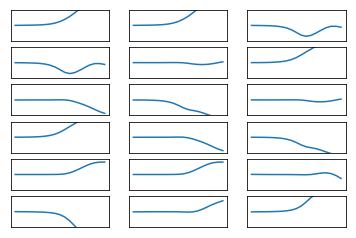




 ------------------




Initialization_function = zeros 
 Activation_Function = sigmoid 
 ALgo = RMSprop



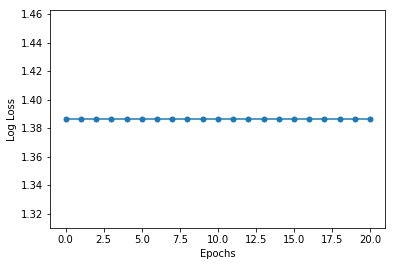

Training accuracy is: 0.2493
Validation accuracy is: 0.252


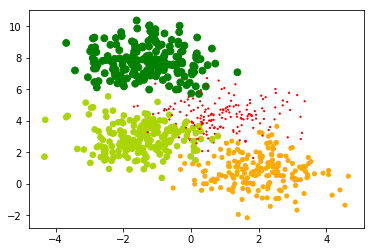

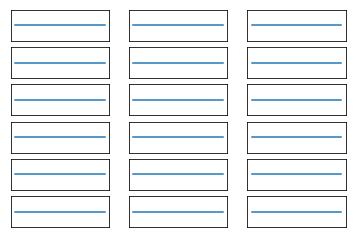




 ------------------




Initialization_function = zeros 
 Activation_Function = sigmoid 
 ALgo = Adam



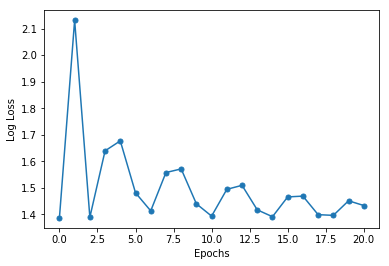

Training accuracy is: 0.2493
Validation accuracy is: 0.252


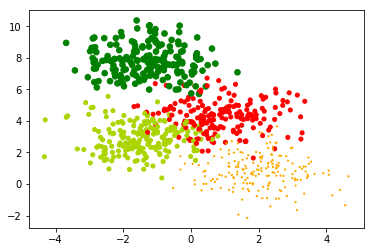

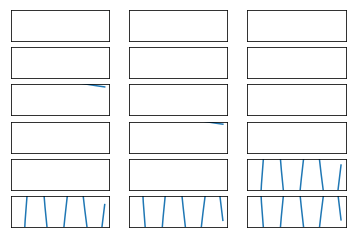




 ------------------




Initialization_function = zeros 
 Activation_Function = sigmoid 
 ALgo = Adagrad



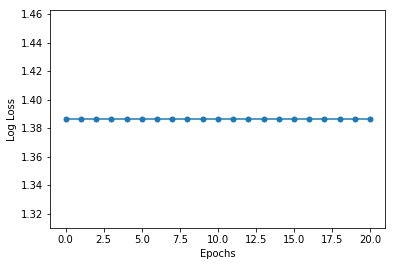

Training accuracy is: 0.2493
Validation accuracy is: 0.252


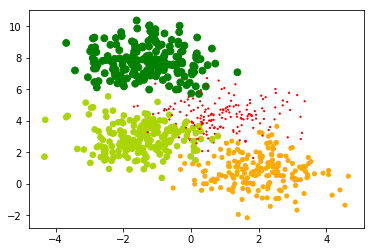

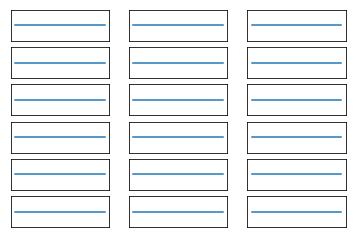




 ------------------




Initialization_function = zeros 
 Activation_Function = tanh 
 ALgo = GD



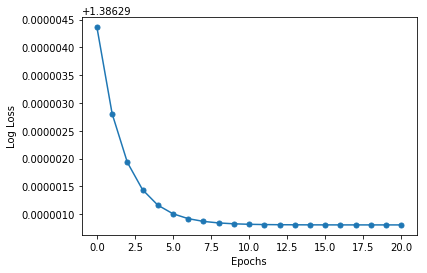

Training accuracy is: 0.2507
Validation accuracy is: 0.248


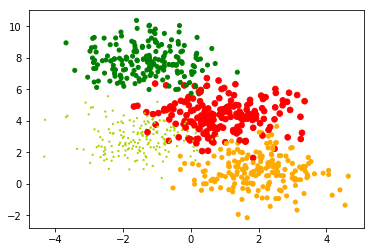

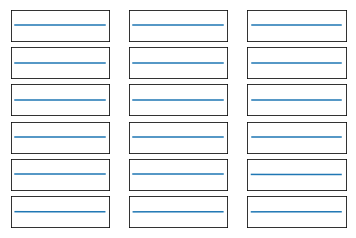




 ------------------




Initialization_function = zeros 
 Activation_Function = tanh 
 ALgo = MiniBatch



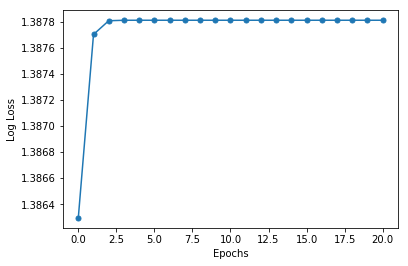

Training accuracy is: 0.2507
Validation accuracy is: 0.248


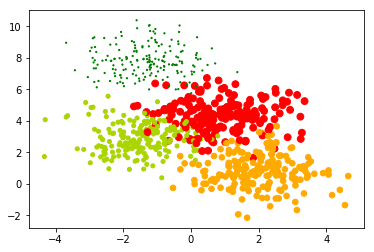

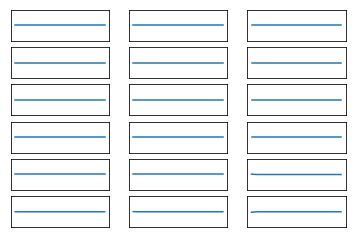




 ------------------




Initialization_function = zeros 
 Activation_Function = tanh 
 ALgo = NAG



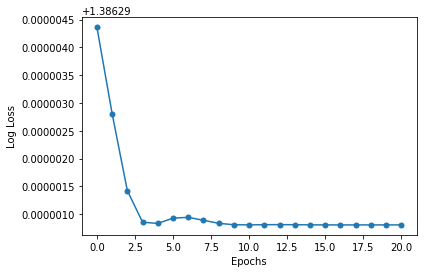

Training accuracy is: 0.2507
Validation accuracy is: 0.248


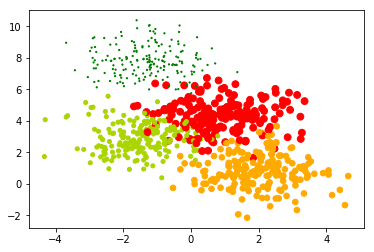

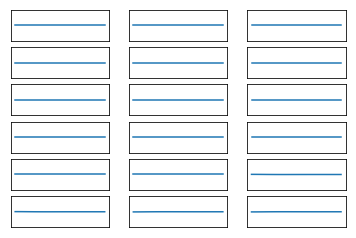




 ------------------




Initialization_function = zeros 
 Activation_Function = tanh 
 ALgo = RMSprop



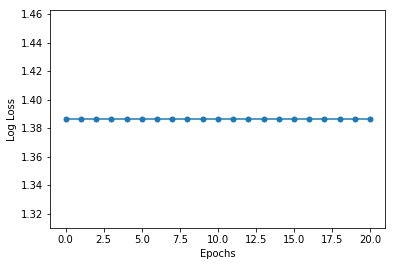

Training accuracy is: 0.2493
Validation accuracy is: 0.252


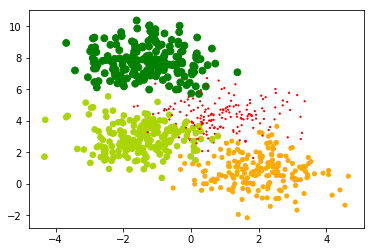

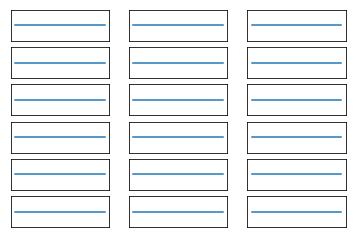




 ------------------




Initialization_function = zeros 
 Activation_Function = tanh 
 ALgo = Adam



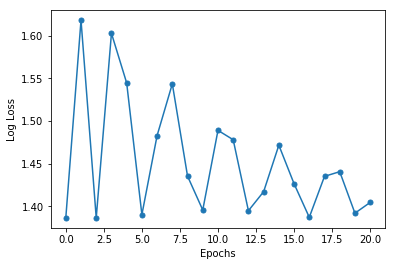

Training accuracy is: 0.2507
Validation accuracy is: 0.248


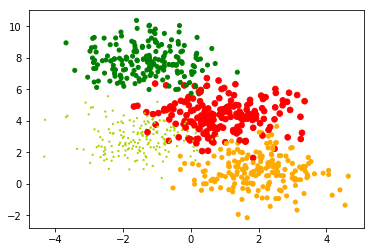

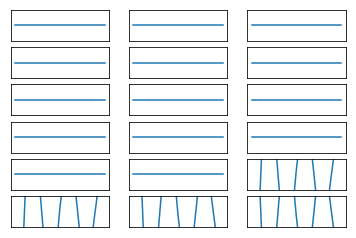




 ------------------




Initialization_function = zeros 
 Activation_Function = tanh 
 ALgo = Adagrad



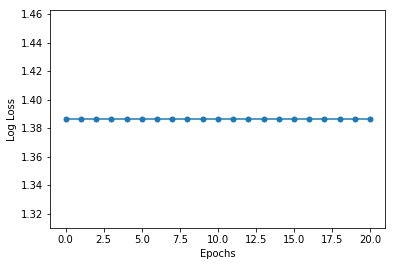

Training accuracy is: 0.2493
Validation accuracy is: 0.252


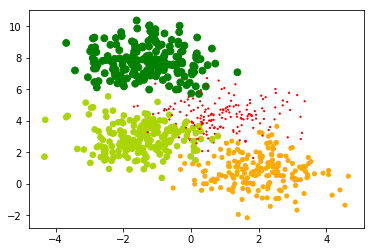

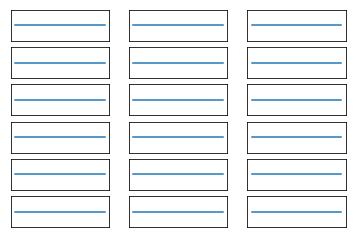




 ------------------




Initialization_function = zeros 
 Activation_Function = relu 
 ALgo = GD



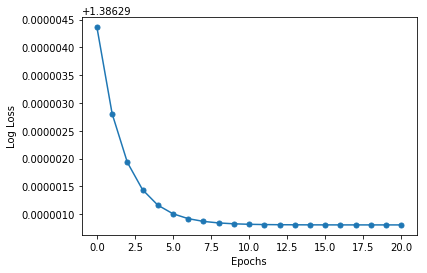

Training accuracy is: 0.2507
Validation accuracy is: 0.248


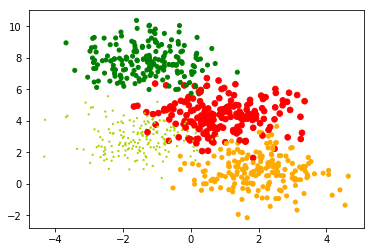

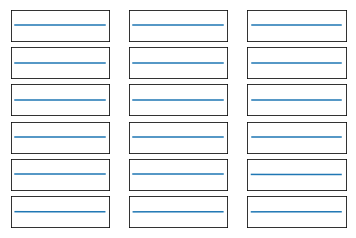




 ------------------




Initialization_function = zeros 
 Activation_Function = relu 
 ALgo = MiniBatch



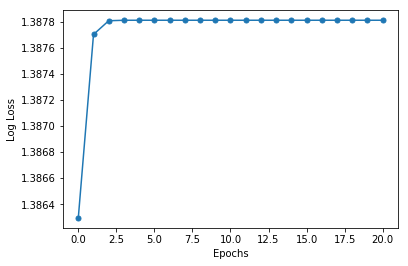

Training accuracy is: 0.2507
Validation accuracy is: 0.248


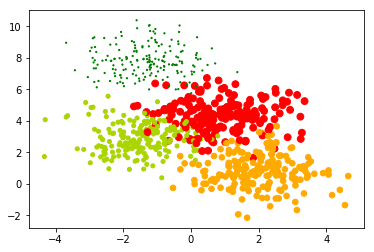

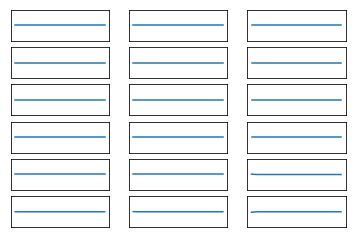




 ------------------




Initialization_function = zeros 
 Activation_Function = relu 
 ALgo = NAG



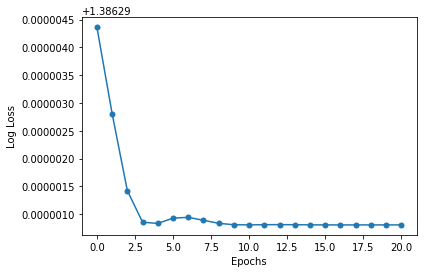

Training accuracy is: 0.2507
Validation accuracy is: 0.248


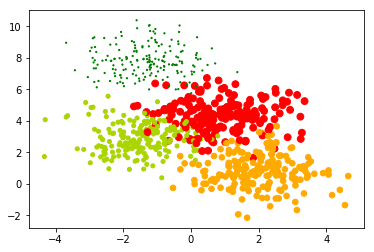

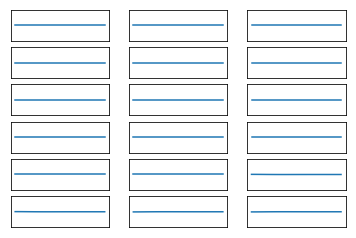




 ------------------




Initialization_function = zeros 
 Activation_Function = relu 
 ALgo = RMSprop



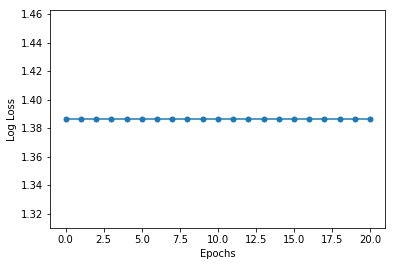

Training accuracy is: 0.2493
Validation accuracy is: 0.252


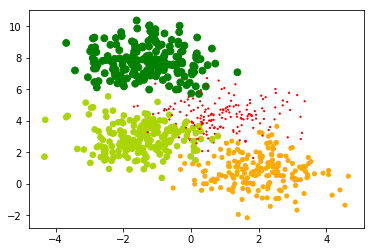

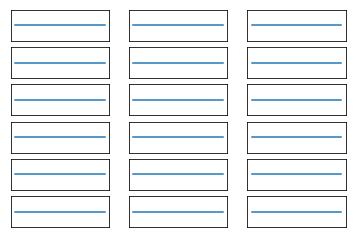




 ------------------




Initialization_function = zeros 
 Activation_Function = relu 
 ALgo = Adam



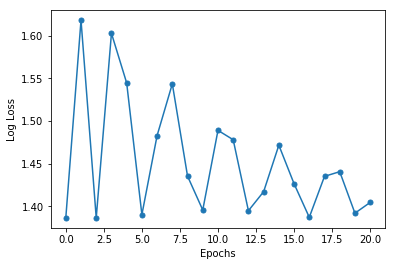

Training accuracy is: 0.2507
Validation accuracy is: 0.248


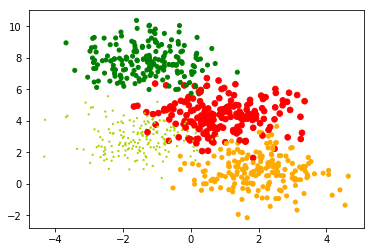

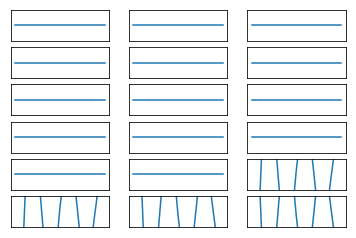




 ------------------




Initialization_function = zeros 
 Activation_Function = relu 
 ALgo = Adagrad



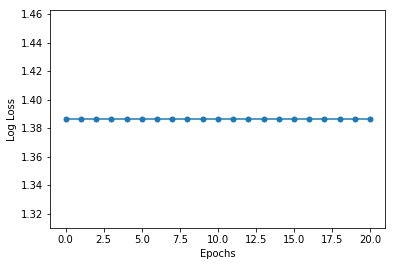

Training accuracy is: 0.2493
Validation accuracy is: 0.252


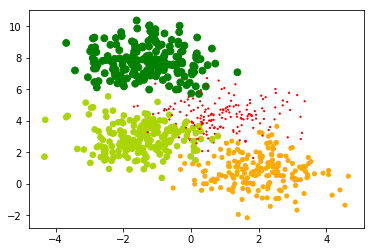

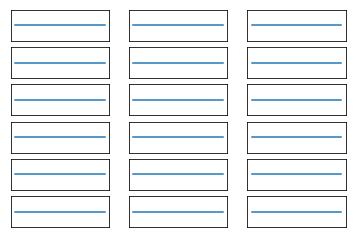




 ------------------




Initialization_function = zeros 
 Activation_Function = leaky_relu 
 ALgo = GD



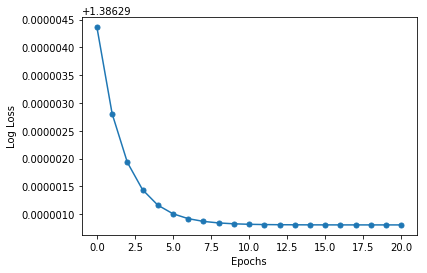

Training accuracy is: 0.2507
Validation accuracy is: 0.248


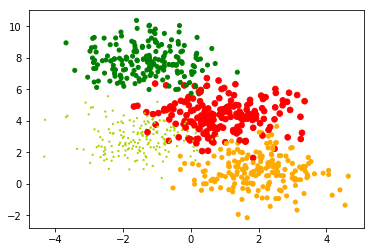

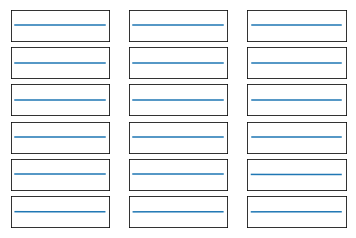




 ------------------




Initialization_function = zeros 
 Activation_Function = leaky_relu 
 ALgo = MiniBatch



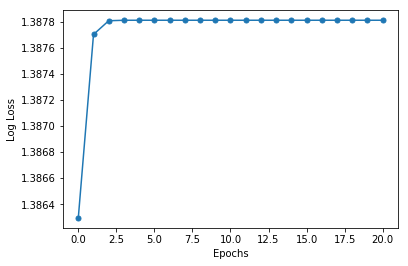

Training accuracy is: 0.2507
Validation accuracy is: 0.248


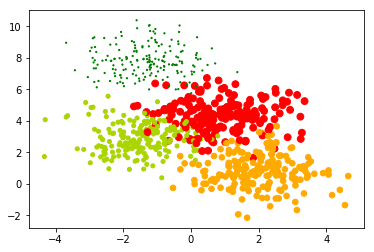

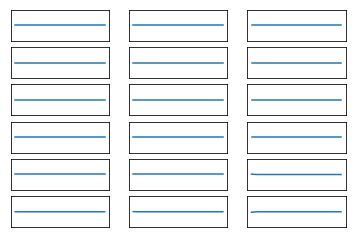




 ------------------




Initialization_function = zeros 
 Activation_Function = leaky_relu 
 ALgo = NAG



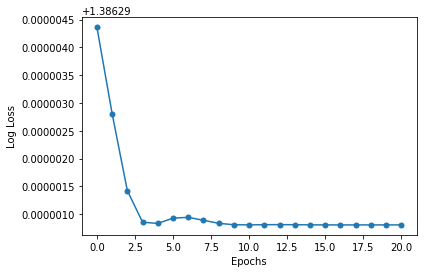

Training accuracy is: 0.2507
Validation accuracy is: 0.248


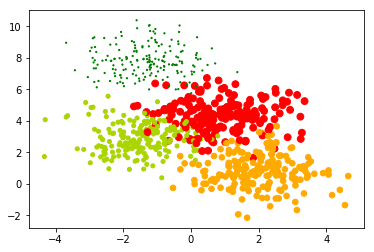

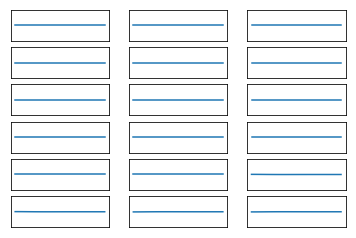




 ------------------




Initialization_function = zeros 
 Activation_Function = leaky_relu 
 ALgo = RMSprop



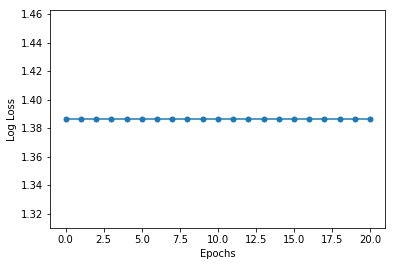

Training accuracy is: 0.2493
Validation accuracy is: 0.252


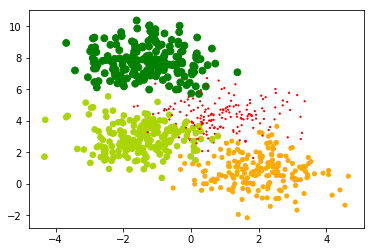

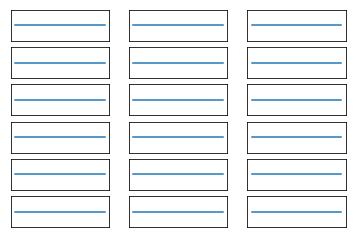




 ------------------




Initialization_function = zeros 
 Activation_Function = leaky_relu 
 ALgo = Adam



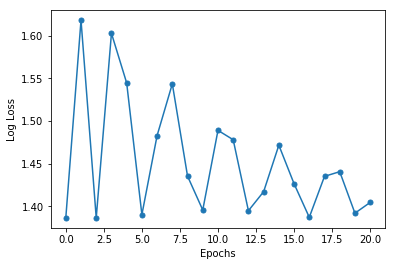

Training accuracy is: 0.2507
Validation accuracy is: 0.248


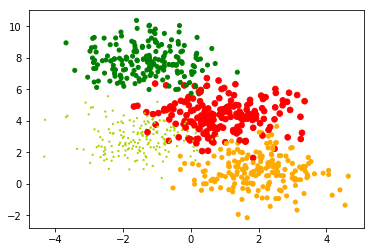

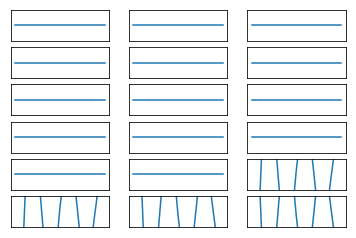




 ------------------




Initialization_function = zeros 
 Activation_Function = leaky_relu 
 ALgo = Adagrad



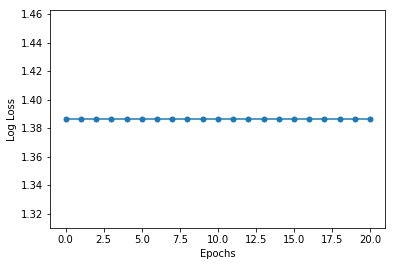

Training accuracy is: 0.2493
Validation accuracy is: 0.252


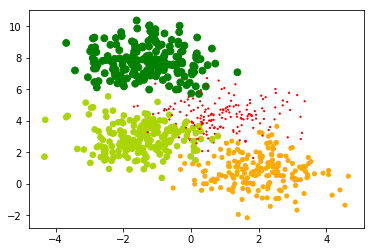

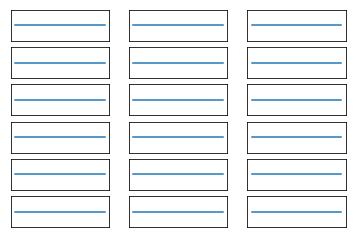




 ------------------




Initialization_function = xavier 
 Activation_Function = sigmoid 
 ALgo = GD



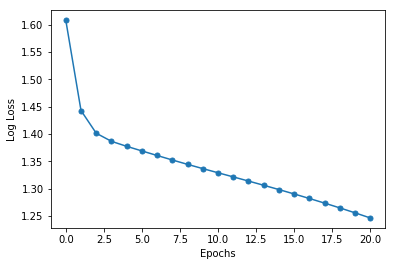

Training accuracy is: 0.4493
Validation accuracy is: 0.444


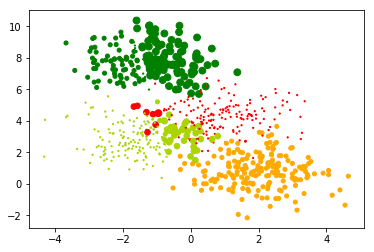

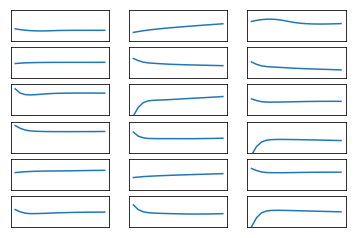




 ------------------




Initialization_function = xavier 
 Activation_Function = sigmoid 
 ALgo = MiniBatch



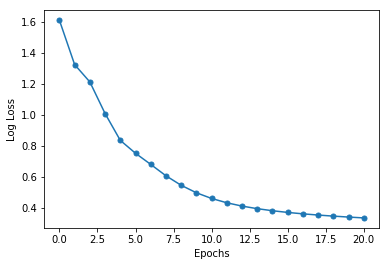

Training accuracy is: 0.8827
Validation accuracy is: 0.892


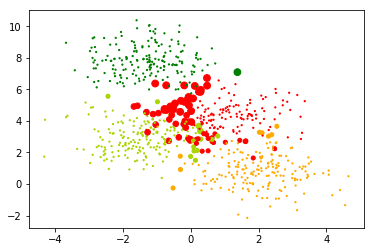

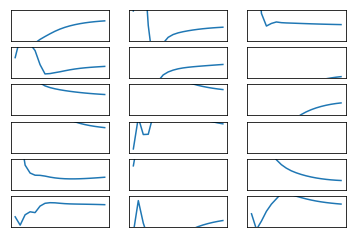




 ------------------




Initialization_function = xavier 
 Activation_Function = sigmoid 
 ALgo = NAG



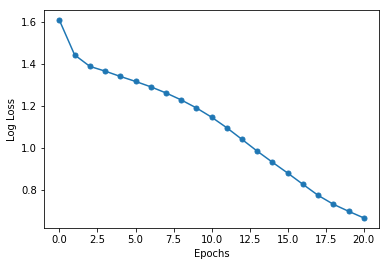

Training accuracy is: 0.856
Validation accuracy is: 0.892


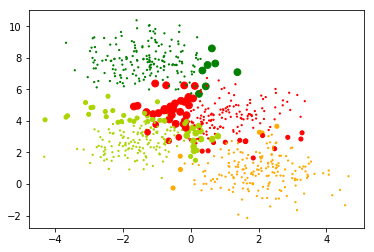

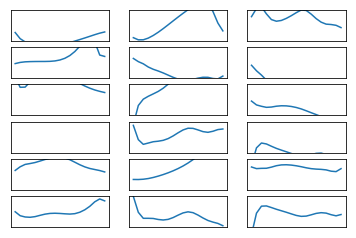




 ------------------




Initialization_function = xavier 
 Activation_Function = sigmoid 
 ALgo = RMSprop



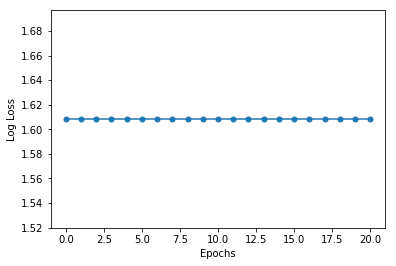

Training accuracy is: 0.2507
Validation accuracy is: 0.248


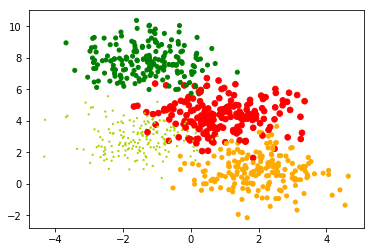

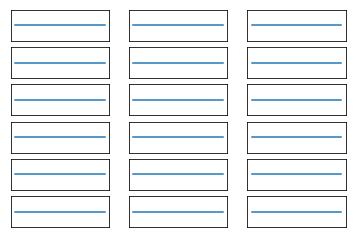




 ------------------




Initialization_function = xavier 
 Activation_Function = sigmoid 
 ALgo = Adam



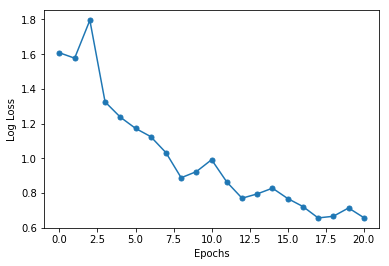

Training accuracy is: 0.6587
Validation accuracy is: 0.688


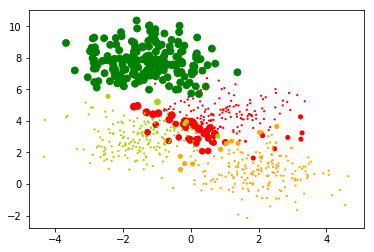

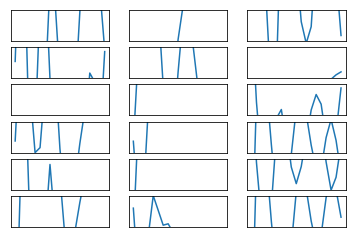




 ------------------




Initialization_function = xavier 
 Activation_Function = sigmoid 
 ALgo = Adagrad



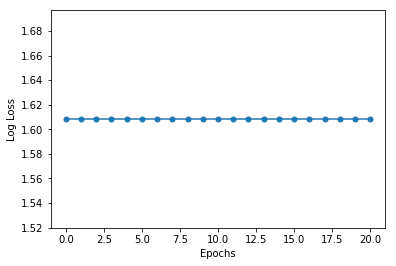

Training accuracy is: 0.2507
Validation accuracy is: 0.248


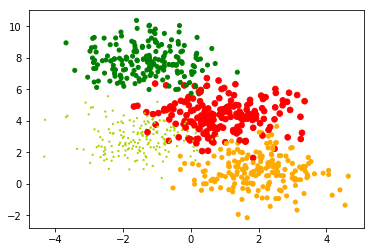

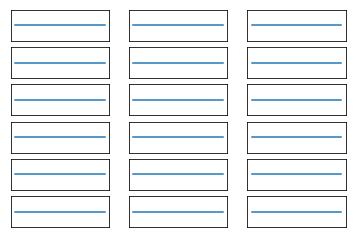




 ------------------




Initialization_function = xavier 
 Activation_Function = tanh 
 ALgo = GD



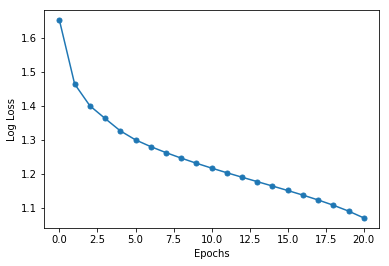

Training accuracy is: 0.5533
Validation accuracy is: 0.532


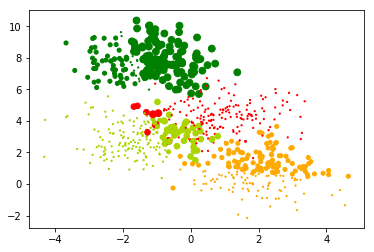

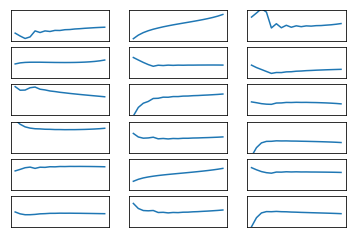




 ------------------




Initialization_function = xavier 
 Activation_Function = tanh 
 ALgo = MiniBatch



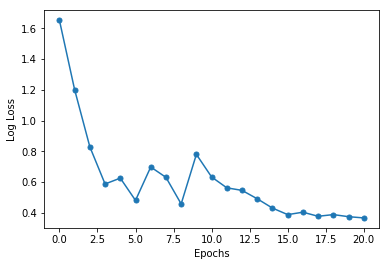

Training accuracy is: 0.8627
Validation accuracy is: 0.884


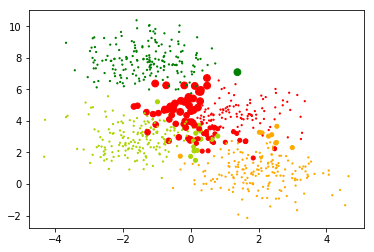

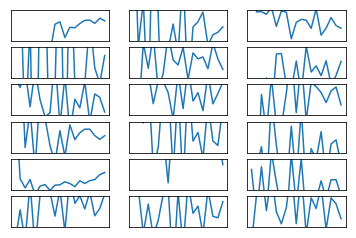




 ------------------




Initialization_function = xavier 
 Activation_Function = tanh 
 ALgo = NAG



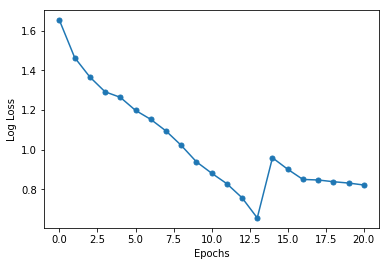

Training accuracy is: 0.564
Validation accuracy is: 0.564


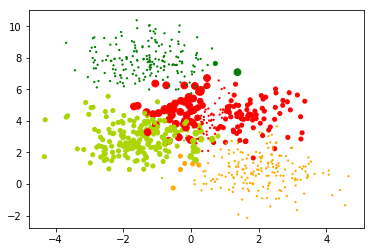

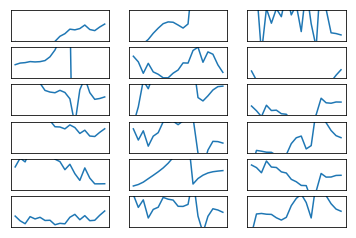




 ------------------




Initialization_function = xavier 
 Activation_Function = tanh 
 ALgo = RMSprop



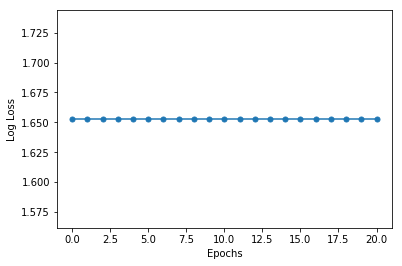

Training accuracy is: 0.2507
Validation accuracy is: 0.248


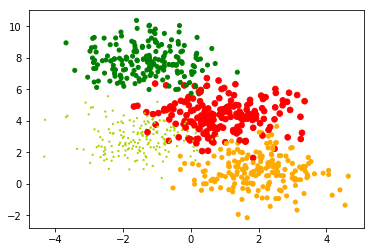

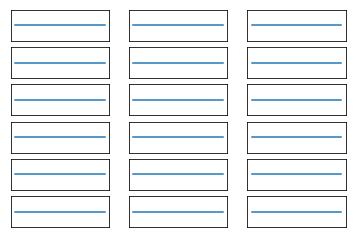




 ------------------




Initialization_function = xavier 
 Activation_Function = tanh 
 ALgo = Adam



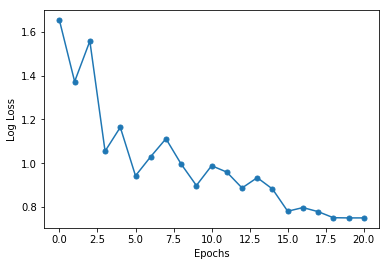

Training accuracy is: 0.6747
Validation accuracy is: 0.664


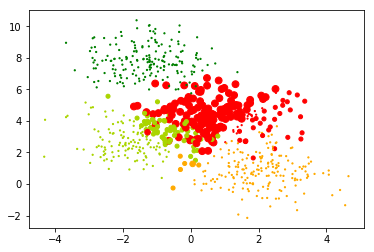

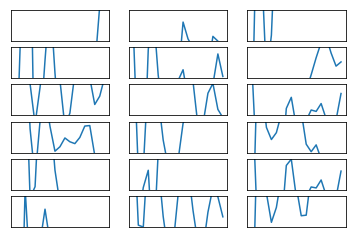




 ------------------




Initialization_function = xavier 
 Activation_Function = tanh 
 ALgo = Adagrad



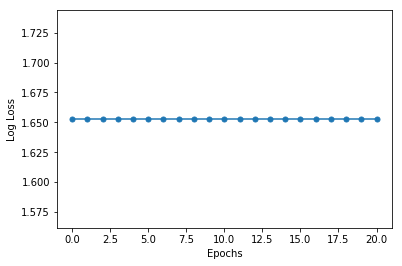

Training accuracy is: 0.2507
Validation accuracy is: 0.248


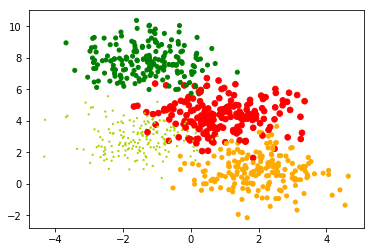

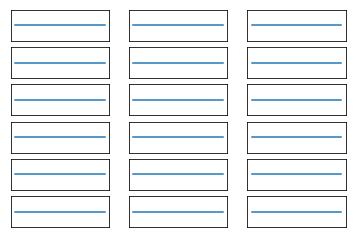




 ------------------




Initialization_function = xavier 
 Activation_Function = relu 
 ALgo = GD



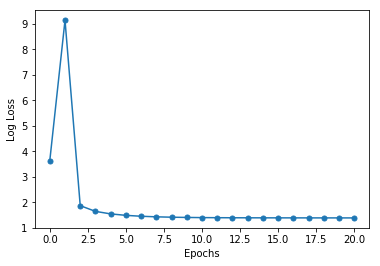

Training accuracy is: 0.2507
Validation accuracy is: 0.252


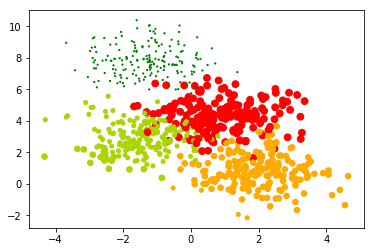

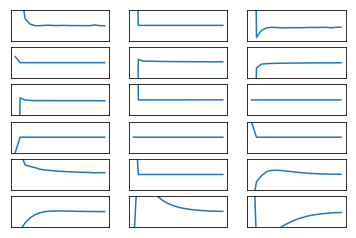




 ------------------




Initialization_function = xavier 
 Activation_Function = relu 
 ALgo = MiniBatch



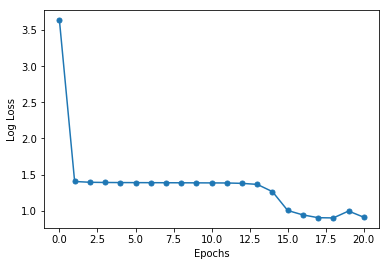

Training accuracy is: 0.4907
Validation accuracy is: 0.496


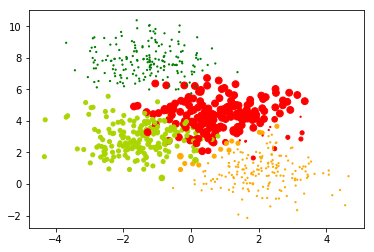

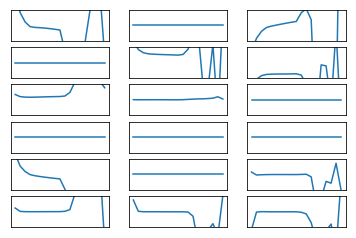




 ------------------




Initialization_function = xavier 
 Activation_Function = relu 
 ALgo = NAG



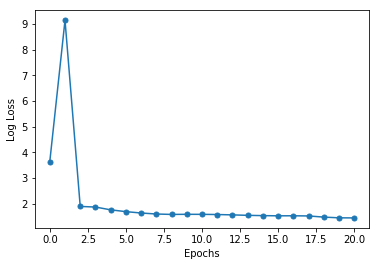

Training accuracy is: 0.2493
Validation accuracy is: 0.252


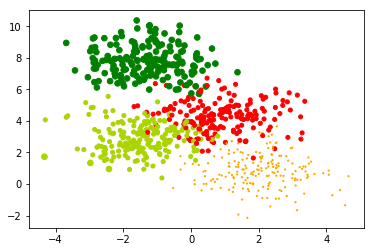

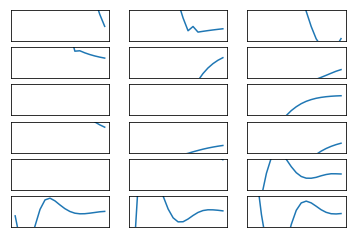




 ------------------




Initialization_function = xavier 
 Activation_Function = relu 
 ALgo = RMSprop



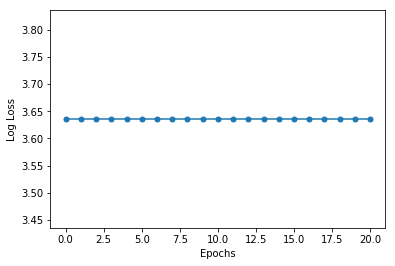

Training accuracy is: 0.1267
Validation accuracy is: 0.12


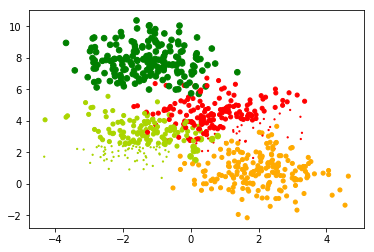

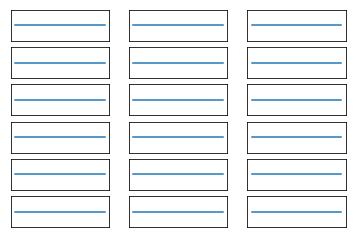




 ------------------




Initialization_function = xavier 
 Activation_Function = relu 
 ALgo = Adam



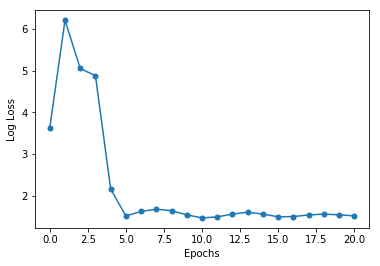

Training accuracy is: 0.2493
Validation accuracy is: 0.252


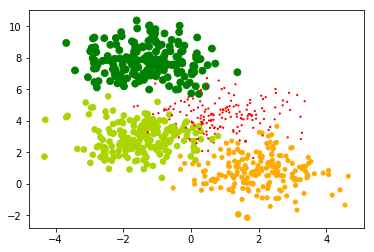

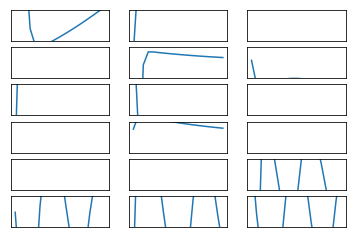




 ------------------




Initialization_function = xavier 
 Activation_Function = relu 
 ALgo = Adagrad



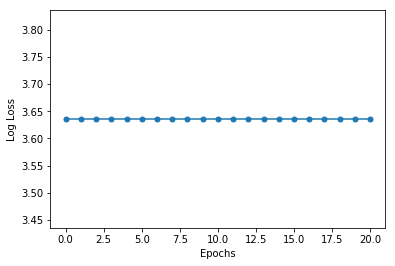

Training accuracy is: 0.1267
Validation accuracy is: 0.12


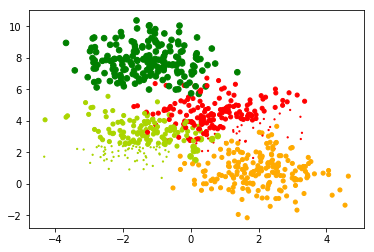

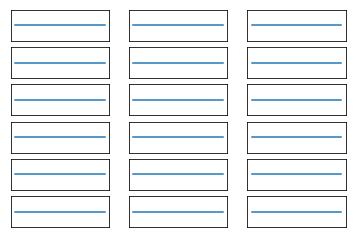




 ------------------




Initialization_function = xavier 
 Activation_Function = leaky_relu 
 ALgo = GD



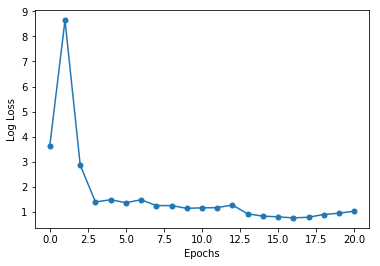

Training accuracy is: 0.448
Validation accuracy is: 0.428


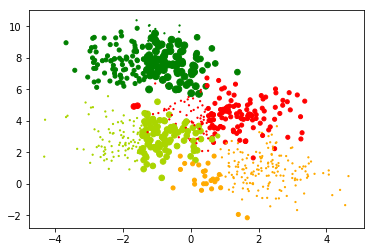

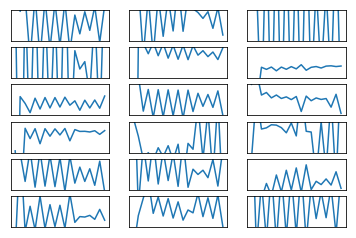




 ------------------




Initialization_function = xavier 
 Activation_Function = leaky_relu 
 ALgo = MiniBatch



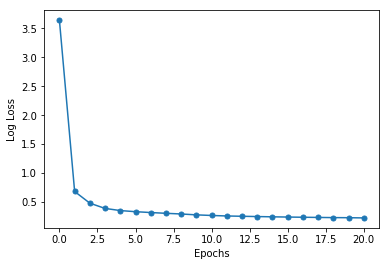

Training accuracy is: 0.9213
Validation accuracy is: 0.94


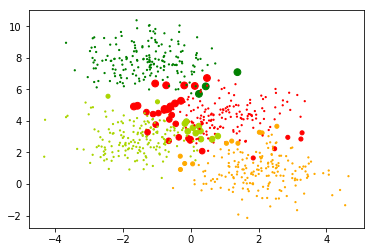

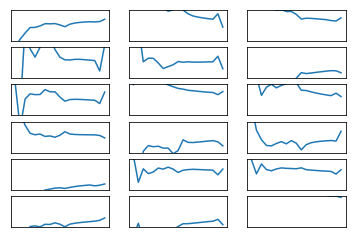




 ------------------




Initialization_function = xavier 
 Activation_Function = leaky_relu 
 ALgo = NAG



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [16]:
for init_fun in ['zeros','xavier','he','random']:
    for activation_fun in ['sigmoid','tanh','relu','leaky_relu']:
        for algo in ['GD','MiniBatch','NAG','RMSprop','Adam','Adagrad']:
            
            print()
            print("Initialization_function =",init_fun,"\n Activation_Function =",activation_fun,"\n ALgo =",algo)
            print()
            model=FFMI(init_fun,activation_fun)
            model.fit(X_train,Y_train_oh,20,algo)
            post_process()
            print("\n\n\n ------------------\n\n\n")